In [1]:
import Pkg

Pkg.activate(@__DIR__)

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [78]:
using Revise
using JuMP
using ToQUBO                 #px/indicator
using DisjunctiveProgramming #master
using DisjunctiveToQUBO
using QUBOTools
using LinearAlgebra
using HiGHS
using DWave

    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/PySA/1uIKV/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/DWave/SF65J/CondaPkg.toml


    CondaPkg Found dependencies: /home/pedroxavier/.julia/packages/PythonCall/wXfah/CondaPkg.toml


    CondaPkg Dependencies already up to date


In [19]:
includet("reactors.jl")

In [4]:
# Set parameters
cx = [1.5, 1]
cy = [6.1, 5.9]
α  = [0.75, 0.8]
d  = 3 # not specified in the problem, I think it is 3

3

$$
\begin{array}{rll}
    \displaystyle \min_{\mathbf{x}, \mathbf{Y}} & \mathbf{c_{x}}'\mathbf{x} + \mathbf{c_{y}}'\mathbf{y} \\
    \textrm{s.t.} & \mathbf{\alpha}'\mathbf{x} \ge d \\[0.75em]
                  & \displaystyle%
                    \bigvee_{i = 1}^{2} \left[\begin{array}{c} Y_{i} \\ x_{i} \leq 0 \end{array}\right] \\[1.75em]
                  & 0 \leq x_{i} \leq 5 & \forall i \\
                  & Y_{i} \iff y_{i} = 1 & \forall i \\
                  & Y_{i} \in \{\textrm{True}, \textrm{False}\} & \forall i \\
                  & y_{i} \in \{0, 1\} & \forall i \\[1em]
   \textrm{data}  & \mathbf{c_{x}} = [1.5, 1] \\
                  & \mathbf{c_{y}} = [6.1, 5.9] \\
                  & \mathbf{\alpha} = [0.75, 8] \\
                  & d = 3
\end{array}
$$

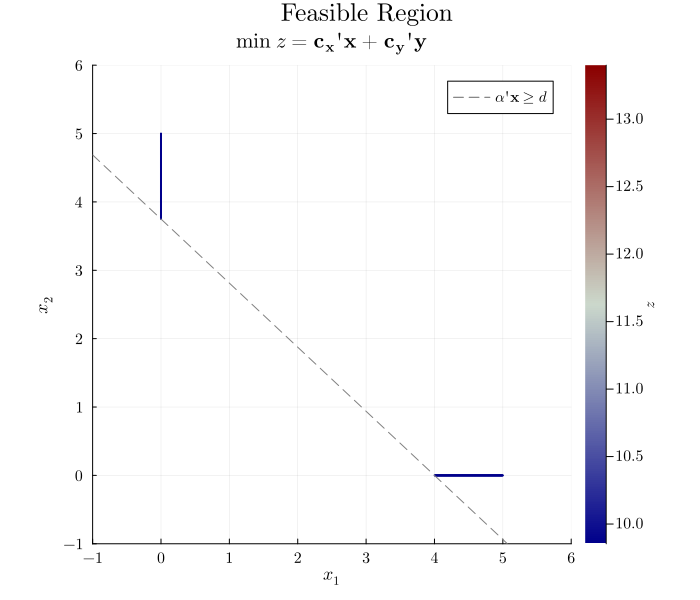

In [75]:
plot_reactor_feasible()

## Optimal Solution

In [57]:
x⃰, z⃰ = let model = solve_gdp_reactors(HiGHS.Optimizer; method=BigM(3.75, false)) do m
        set_silent(m)
    end
b
    value.(model[:x]), objective_value(model)
end

([0.0, 3.75], 9.85)

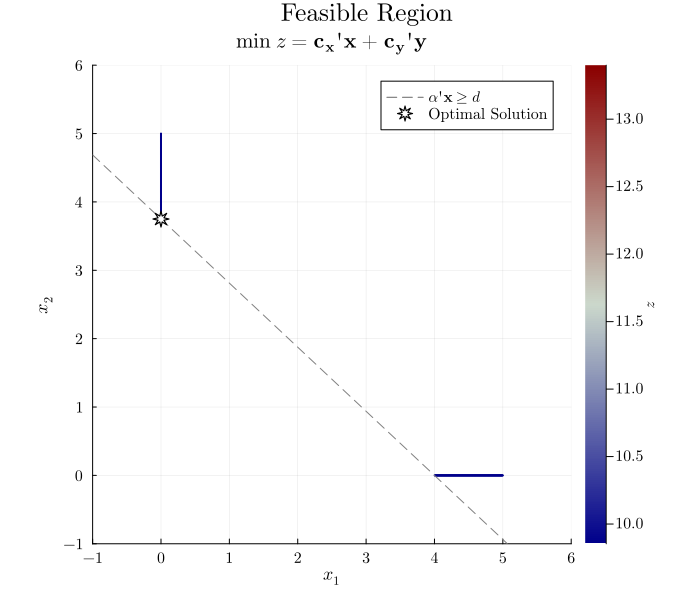

In [76]:
plot_reactor_optimal(x⃰)

## Big-$M$ Reformulation

In [84]:
M = 3.75

bigm_model = solve_gdp_reactors(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(bigm_model)
solution_summary(bigm_model)
sampling_summary(bigm_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 21
  Encoding ………………… 10
  Slack ………………………… 11
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.6476190476190476

⋄ Coefficient Range
  Lower Bound ………… -32766.25
  Upper Bound ………… 104448.0

⋄ Constant Offset: 59236.5

⋄ Work counters
  Compiltaion Time (sec) : 0.000398494

⋄ Sampling Summary

⋄ Number of samples: 537

⋄ Best energy: 9.849999999998545

⋄ Time-to-target (sec): 846.8548752206545



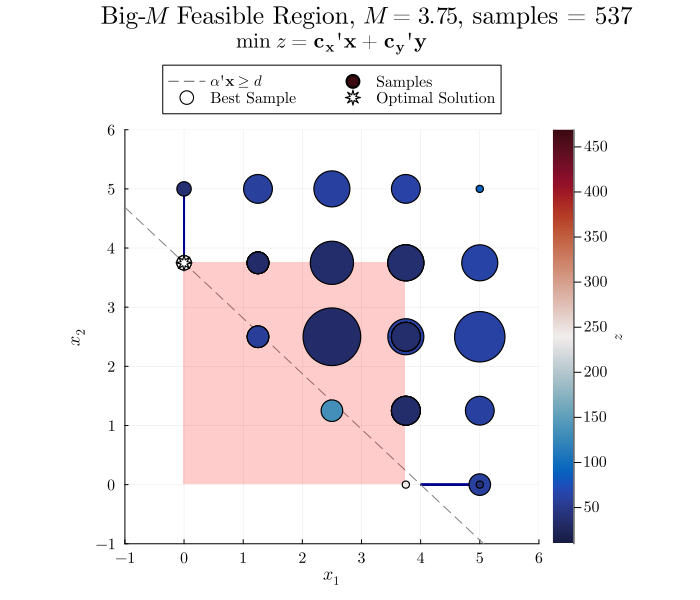

In [89]:
plot_reactor_bigm(bigm_model, x⃰, M)